In [1]:
#import plotly.graph_objects as go
#import plotly.express as px
import numpy as np
import pandas as pd
from datetime import datetime
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import math
import requests
import sqlite3
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import fantasy_utils as fu

In [2]:
#conn = sqlite3.connect('fantasy_data.db')
#conn.create_function('sqrt', 1, math.sqrt)
#cursor = conn.cursor()

In [3]:
from sqlalchemy import MetaData, text, Column, Integer, String, ForeignKey, Table, create_engine, Float, Boolean, DateTime
from sqlalchemy.orm import relationship, backref, sessionmaker, declarative_base
from sqlalchemy.sql.sqltypes import DATETIME
#from sqlalchemy.ext.declarative import declarative_base

meta = MetaData()
engine = create_engine('sqlite:///fantasy_data.db', echo=False)
Session = sessionmaker(bind=engine)
session = Session()
Base = declarative_base()

players = Table('players'+str(datetime.now().year), meta,
                Column('cbsid', Integer, primary_key=True),
                Column('Paid', Integer),
                Column('Supp', Integer),
                Column('Owner', String(25)),
                Column('Timestamp', DATETIME)
    )

In [4]:
def generate_bids(player_value, team_budgets, skew_factor=1.2, std_dev=0.3, soft_cap=True):
    """
    Generate bids with an optional soft cap to smooth the distribution.

    Parameters:
    - player_value: Estimated value of the player.
    - team_budgets: List of team budgets.
    - skew_factor: Multiplier for maximum bid cap.
    - std_dev: Standard deviation of the log-normal distribution.
    - soft_cap: Whether to apply a soft cap to reduce spikes at the max value.

    Returns:
    - List of bids.
    """
    bids = []
    max_bid = player_value * skew_factor
    for budget in team_budgets:
        # Log-normal distribution for right-skewed bids
        mean = np.log(player_value)
        raw_bid = np.random.lognormal(mean, std_dev)

        # Apply soft or hard cap
        if soft_cap:
            # Gradually penalize bids near or above the max
            bid = raw_bid if raw_bid <= max_bid else max_bid * (1 - np.random.random() * 0.2)
        else:
            # Hard cap
            bid = min(raw_bid, max_bid)
        
        # Ensure bid is within budget
        bid = min(bid, budget)
        bids.append(int(bid))
    return bids

def plot_distribution(player_value, std_dev, skew_factor=1.2, samples=10000, soft_cap=True):
    """
    Plot the distribution of potential bids with optional soft cap.

    Parameters:
    - player_value: Estimated value of the player.
    - std_dev: Standard deviation of the log-normal distribution.
    - skew_factor: Multiplier for maximum bid cap.
    - samples: Number of samples to generate.
    - soft_cap: Whether to apply a soft cap.
    """
    max_bid = player_value * skew_factor
    mean = np.log(player_value)
    values = np.random.lognormal(mean, std_dev, samples)
    
    # Apply cap to the values
    if soft_cap:
        capped_values = [v if v <= max_bid else max_bid * (1 - np.random.random() * 0.2) for v in values]
    else:
        capped_values = np.minimum(values, max_bid)
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(capped_values, bins=50, color='blue', alpha=0.7, edgecolor='black')
    plt.axvline(player_value, color='red', linestyle='--', label='Player Value')
    plt.title(f"Distribution of Bids (Player Value: {player_value}, Std Dev: {std_dev})")
    plt.xlabel("Bid Amount")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
player_value = 25
#team_budgets = [200, 180, 160, 150, 140, 130, 120, 110, 100, 90, 80]
team_budgets = [260]*11

Generated Bids: [28, 15, 18, 23, 18, 13, 13, 34, 33, 17, 16]


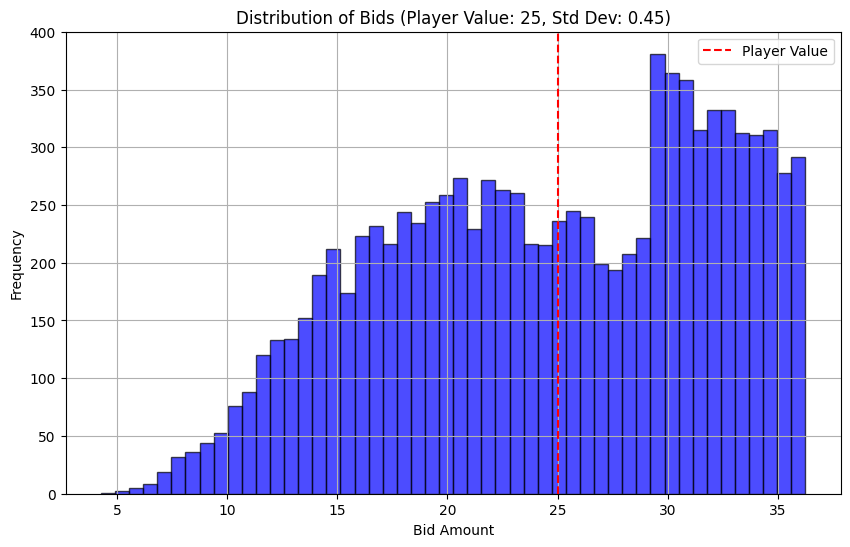

In [5]:
player_value = 25
skew_factor = 1.45
std_dev = .45

# Generate bids with soft cap
bids = generate_bids(player_value, team_budgets, skew_factor=skew_factor, std_dev=std_dev, soft_cap=True)
print("Generated Bids:", bids)

# Plot the distribution with soft cap
plot_distribution(player_value, std_dev=std_dev, skew_factor=skew_factor, soft_cap=True)

In [6]:
def get_rem_dollars(x):
    return 260 - x.sum()


def find_bid_winner(bids, owners, offer):
    orig_order = [i[1] for i in enumerate(owners.keys())] #list(owners.keys())
    owners_key = {tm:i for i, tm in enumerate(orig_order)}
    bid_order = orig_order[orig_order.index(offer):]+orig_order[:orig_order.index(offer)] #bid_order[offer:]+bid_order[:offer]
    bids = bids[owners_key[offer]:] + bids[:owners_key[offer]]
    current_bid = 0
    bid_complete = 0
    max_bid_round = max(bids)
    
    while current_bid < 60:
        if current_bid == max_bid_round:
            break
        if bid_complete == 1:
            break
        for n, owner in enumerate(bid_order):
            if len([i for i, val in enumerate(bids) if val >= current_bid]) < 2:
                #print(f'Bidding is complete. {bid_winner} wins with bid of {current_bid}')
                bid_complete = 1
                break
            elif current_bid >= bids[n]:
                #print(f"current bid is {current_bid}. {owner}'s top bid of {bids[n]} has been met, therefore this owner is done, current bid remains the same")
                pass
            else:
                bid_winner = owner
                current_bid += 1
                #print(f"current bid is {current_bid-1}, {len([i for i, val in enumerate(bids) if val >= current_bid])} -- {owner} max bid is {bids[n]} therefore {owner} raises bid to {current_bid}")
    return bid_winner, current_bid

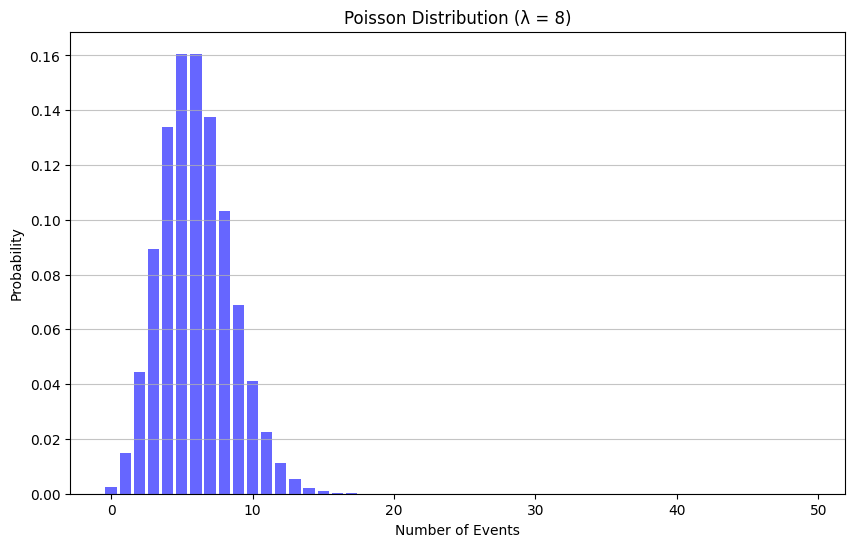

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Parameter for the Poisson distribution
lambda_ = 6  # Average number of events

# Generate the distribution
x = np.arange(0, 50)  # Range of events to consider
pmf = poisson.pmf(np.arange(0, 50), lambda_)
#pmf = [.05, .15, .15, .15, .2, .1, .05, .05, .05, .05]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(x, pmf, alpha=0.6, color='b')
plt.title(f'Poisson Distribution (λ = 8)')
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [8]:
sum(pmf[8:])

0.25602023954628284

In [9]:
pmf = poisson.pmf(np.arange(0, 50), 6)
bids = np.random.choice(np.arange(len(pmf)), size=12, p=pmf)
bids

array([8, 4, 3, 6, 5, 5, 6, 5, 4, 8, 4, 9])

In [10]:
for bid in bids:
    print(f'if player value = 5, then 5 - 8 is -3 so a value of {bid} is equivalent to {bid - -3}')

if player value = 5, then 5 - 8 is -3 so a value of 8 is equivalent to 11
if player value = 5, then 5 - 8 is -3 so a value of 4 is equivalent to 7
if player value = 5, then 5 - 8 is -3 so a value of 3 is equivalent to 6
if player value = 5, then 5 - 8 is -3 so a value of 6 is equivalent to 9
if player value = 5, then 5 - 8 is -3 so a value of 5 is equivalent to 8
if player value = 5, then 5 - 8 is -3 so a value of 5 is equivalent to 8
if player value = 5, then 5 - 8 is -3 so a value of 6 is equivalent to 9
if player value = 5, then 5 - 8 is -3 so a value of 5 is equivalent to 8
if player value = 5, then 5 - 8 is -3 so a value of 4 is equivalent to 7
if player value = 5, then 5 - 8 is -3 so a value of 8 is equivalent to 11
if player value = 5, then 5 - 8 is -3 so a value of 4 is equivalent to 7
if player value = 5, then 5 - 8 is -3 so a value of 9 is equivalent to 12


In [11]:
# Dynamic max_bid dictionary
max_bid_mult = {a:b for a, b in zip(list(range(1,46)), [3,2.5,2.2,1.9,1.8,1.7,1.6,1.55,1.5,1.4,1.35,1.34,1.33,1.32,1.31,1.30,1.29,1.28,1.27,1.26,1.25,1.24,1.23,1.22,1.21,1.20,1.19,1.18,1.17,1.16,1.15,1.14,1.13,1.12,1.11,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1])}

def calculate_max_bid(player_value):
    """
    Dynamically calculate the max bid factor based on the player's value.
    """
    if player_value > 45:
        return 1.1 * player_value
    else:
        return max_bid_mult.get(player_value) * player_value


def bid_distribution(lambda_ = 5):
    pmf = poisson.pmf(np.arange(0, 50), lambda_)
    return 


def simulate_auction_bids(player_data, owners, rosters, timidness=0.1, nominating_team=None):
    """
    Simulate an auction draft where teams bid on a player.
    
    Parameters:
    - player_data: dict of info about a player
    - owners: dict of owners, needs to include current funds available
    - rosters: dataframe of current state of roster for each team with positions as index
    - timidness: Higher values make teams more timid about bidding as bids increase.
    - nominating_team: str, name of team making the nomination
    Returns:
    - A list of bids (0 means no bid) for each team.
    """
    
    #player_value = int(((max(player_data['CBS'],0) + max(player_data['Dollars'],0) + max(player_data['Value'],0))/3.))
    player_value = int(player_data['CBS'])
    if player_value <= 1:
        player_value = 1
    player_pos = player_data['Pos']
    elig_list = []
    for pos in player_data['Pos'].split(','):
        elig_list.extend(pos_elig[pos])

    max_bid = calculate_max_bid(player_value)
    bids = []
    
    for k,v in owners.items():
        # Checks to see if the team has one of the player's positions available
        if rosters.applymap(lambda x: 0 if isinstance(x, str) and any(char.isalpha() for char in x) else 1).loc[elig_list, k].sum() <= 0:
            print(f"{k} ineligible to bid on player")
            bids.append(0)
        else:
            # Set budget and team's max bid as constraints
            budget = v['$ Left']
            team_max_bid = math.floor(v['max_bid'])
                
            # Probability of bidding decreases as the bid approaches max_bid
            bid_probability = max(0.1, 1 - timidness * (max_bid / player_value - 1))
            if np.random.random() > bid_probability or team_max_bid < player_value * 0.5:
                # Skip bidding due to budget or preference
                if k == nominating_team:
                    bids.append(1)
                else:
                    bids.append(0)
            else:
                # Generate a bid with some randomness
                # Do not allow a bid higher than team's max bid
                #bid = np.random.uniform(max(0, player_value * 0.7), min(team_max_bid, max_bid))
                pmf = poisson.pmf(np.arange(0, 50), 5)
                bid = np.random.choice(np.arange(len(pmf)), size=1, p=pmf)
                bid = min((player_value - 8) + bid, max_bid)
                if bid < 0:
                    bid = 0
                # Make sure nominating team bids 1
                if k == nominating_team:
                    bid = max(1, bid)
                bids.append(min(bid, budget))  # Respect team budgets
    
    # Round bids to integers for realism
    return [int(bid) for bid in bids]



def complete_bid(player_data, owners_df, rosters, timidness, offer):
    """
    Runs simulate_auction function to get bids. Then finds the winner and sends to /update_bid endpoint to update database.

    - player_data:
    - owners:
    - rosters: 
    - timidness: 
    - offer:
    
    """
    player_value = max(player_data['CBS'], player_data['Dollars'])
    timidness = 0.3  # Adjust timidness to control bidding behavior
    
    bids = simulate_auction(player_data, owners_df, rosters, timidness=timidness)
    
    print("Generated Bids:", bids)
    plot_auction_bids(bids, player_value)
    
    winning_owner, winning_bid = find_bid_winner(bids, owners_df, offer)
    offer = winning_owner
    print(winning_owner, winning_bid)
    
    # Update database
    url = 'http://localhost:8000/draft/update_bid'
    params = {'cbsid': cbsid, 'price': winning_bid, 'owner': winning_owner}
    r = requests.get(url, params)
    
    if r.status_code == 200:
        h = pd.read_sql(f"SELECT * FROM players{datetime.now().year} WHERE cbsid IS NOT NULL", engine)
        owners_df = pd.read_html(r.text)[2]
        owners_df.fillna({'$ Left':260, 'Max Bid':237, 'Drafted':0},inplace=True)
        owners_df = owners_df.set_index('Owner').reindex(owner_sort)
        owners_df.fillna({'$ Left':260, 'Max Bid':237, 'Drafted':0, '$ Left/Plyr':11.3},inplace=True)
        owners_df['$ Left'] = owners_df['$ Left'].astype(int)
        rosters = pd.read_html(r.text)[3]
        rosters = rosters.set_index('Pos')
    return h, owners_df, rosters



def plot_auction_bids(bids, player_value):
    """
    Visualize the bids from the auction simulation.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(bids)), bids, color="blue", alpha=0.7, edgecolor="black")
    plt.axhline(player_value, color="red", linestyle="--", label="Player Value")
    plt.title("Auction Bids by Team")
    plt.xlabel("Team")
    #ax.set_xticklabels(['9 Grand Kids', 'Brewbirds', 'Charmer', 'Dirty Birds', 'Harvey', 'Lima Time', 'Mother', 'Roid Ragers', 'Trouble', 'Ugly Spuds', 'Wu-Tang', 'Young Guns'])
    plt.ylabel("Bid Amount")
    plt.legend()
    plt.grid()
    plt.show()


In [12]:
def get_owners(df):
    owners_df = df.query('Paid>0').groupby('Owner').agg({'Name':'count', 'Paid':'sum', 'z':'sum', 'H':'sum', 'AB':'sum', 'HR':'sum', 'R':'sum', 'RBI':'sum', 'SB':'sum', 'Outs':'sum', 'QS':'sum', 'SO':'sum', 'SvHld':'sum', 'ER':'sum', 'IP':'sum', 'BB':'sum', 'HA':'sum'}).reset_index()
    owners_df.rename(columns={'Name':'Drafted'},inplace=True)
    owners_df['Paid'] = owners_df['Paid'].apply(lambda x: int(x) if x>0 else x)
    owners_df['$/unit'] = round(owners_df['Paid']/owners_df['z'],1)
    owners_df['z'] = round(owners_df['z'],1)
    owners_df['$ Left'] = tm_dollars - owners_df['Paid']
    owners_df['$ Left / Plyr'] = round(owners_df['$ Left'] / (tm_players -owners_df['Drafted']),1)
    owners_df['max_bid'] = owners_df['$ Left'] - (tm_players - owners_df['Drafted']) + 1
    owners_df['Cash'] = round(owners_df['$ Left / Plyr'] / (((tot_dollars - owners_df.Paid.sum()) + owners_df['Paid']) / ((tot_players - owners_df.Drafted.sum()) + owners_df['Drafted'])),2)
    owners_df['Value'] = round((owners_df['z']*orig_conv) - owners_df['Paid'],1)
    owners_df['BA'] = round(owners_df['H']/owners_df['AB'],3)
    owners_df['ERA'] = round(owners_df['ER']/(owners_df['Outs']/3)*9,2)
    owners_df['WHIP'] = round((owners_df['BB']+owners_df['HA'])/(owners_df['Outs']/3),2)
    owners_df['Pts'] = 0
    for i in ['BA', 'HR', 'R', 'RBI', 'SB', 'ERA', 'WHIP', 'QS', 'SO', 'SvHld']:
        owners_df['Pts'] += owners_df[i].rank()
    owners_df['Rank'] = owners_df['Pts'].rank()
    return owners_df.set_index('Owner')


def build_roster(n_teams, owner_list, df, pos_order):
    roster = pd.DataFrame(index=['C', '1B', '2B', '3B', 'SS', 'MI', 'CI', 'OF1', 'OF2', 'OF3', 'OF4', 'OF5', 'DH1', 'DH2', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 
                             'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10'], data=np.zeros((33,n_teams)), columns=owner_list)
    #roster = roster.astype(str)
    
    for tm in owner_list:
        for i, row in df[df['Owner']==tm][['cbsid', 'Name', 'Owner', 'Pos', 'Paid', 'Supp', 'Team', 'Timestamp', 'Keeper', 'Value']].sort_values("Timestamp").iterrows():
            if row['Paid']==0:
                #print(df.loc[i]['Name'], 'B'+str(int(row['Supp'])))
                roster.loc['B'+str(int(row['Supp'])),tm] = row['Name']
                #fu.check_roster_pos(df.loc[i][cols].to_dict(), roster, df, 'B'+str(int(df.loc[i]['Supp'])), pos_order)
            else:
                if row['Paid'] > 0:
                    # Send info to check_roster_pos: Name, Owner, Primary_Pos, Eligible Pos list
                    #print(row['Name'], row['Timestamp'])
                    results = fu.check_roster_pos(row[['cbsid', 'Name', 'Owner', 'Pos', 'Paid', 'Supp', 'Team', 'Timestamp', 'Keeper', 'Value']].to_dict(), roster, df, pos_order)
                    #print(results)
                    for result in results:
                        for item in result.items():
                            if item[1] != None:
                                roster.loc[item[1],tm] = item[0]
    return roster

In [13]:
def refresh_data(n_teams=12, engine=engine):
    # Most recent data from database
    df = pd.read_sql(f"SELECT * FROM players{datetime.now().year} WHERE cbsid IS NOT NULL", engine)

    # Owners table refreshed as well
    owners = get_owners(df)

    # Make sure there's easy access to a list of owners
    owner_list = [owners.to_dict(orient='index').keys()]
    if len(owner_list) < n_teams:
        owner_list = ["9 Grand Kids", 'Brewbirds', 'Charmer', 'Dirty Birds', 'Harvey', 'Lima Time', 'Mother', 'Roid Ragers', 'Trouble', 'Ugly Spuds', 'Wu-Tang', 'Young Guns']

    # Build df of current state of rosters
    rosters = build_roster(n_teams, owner_list, df, fu.pos_order)
    return df, owners, owner_list, rosters

def update_db(price, owner, cbsid, players=players, engine=engine, supp=0):
    conn = engine.connect()
    meta.create_all(engine)
    conn.execute(players.update().values(Paid=price, Supp=supp, Owner=owner, Timestamp=datetime.now()).where(players.c.cbsid==cbsid))
    conn.commit()
    conn.close()
    return 'db updated'

In [14]:
# Initialize some variables
pos_elig = {
    'C':['C', 'DH1', 'DH2'],
    '1B':['1B', 'CI', 'DH1', 'DH2'],
    '2B':['2B', 'MI', 'DH1', 'DH2'],
    '3B':['3B', 'CI', 'DH1', 'DH2'],
    'SS':['SS', 'MI', 'DH1', 'DH2'],
    'OF':['OF1', 'OF2', 'OF3', 'OF4', 'OF5', 'DH1', 'DH2'],
    'DH':['DH1', 'DH2'],
    'SP':['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9'],
    'RP':['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9'],
    'P':['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']
}
owner_sort = ["9 Grand Kids", 'Brewbirds', 'Charmer', 'Dirty Birds', 'Harvey', 'Lima Time', 'Mother', 'Roid Ragers', 'Trouble', 'Ugly Spuds', 'Wu-Tang', 'Young Guns']
# Reverse order of previous year's final standings
owner_list_sorted = ['Dirty Birds', 'Mother', 'Young Guns', 'Trouble', 'Wu-Tang', 'Ugly Spuds', 'Roid Ragers', '9 Grand Kids', 'Charmer', 'Brewbirds', 'Lima Time', 'Harvey']
n_teams = 12
tm_players = 23
tm_dollars = 260
player_split = .67
pitcher_split = 1 - player_split
tot_dollars = n_teams * tm_dollars
tot_players = n_teams * tm_players
tot_hitters = n_teams * 14
tot_pitchers = n_teams * 9
total_z_over_0 = pd.read_sql(f'SELECT sum(z) z FROM players{str(datetime.now().year)} WHERE z>0', engine).iloc[0]['z']
orig_conv =  (tm_dollars/tm_players)*(tot_players/total_z_over_0)

#### Order of operations:
<ol>
    <li>Nominate a player</li>
    <li>Get list of bids</li>
    <li>Choose winner of bids</li>
    <li>Update database with the winner</li>
    <li>Update roster as well</li>
</ol>

In [30]:
df, owners, owner_list, rosters = refresh_data()
owners

,Drafted,Paid,z,H,AB,HR,R,RBI,SB,Outs,QS,SO,SvHld,ER,IP,BB,HA,$/unit,$ Left,$ Left / Plyr,max_bid,Cash,Value,BA,ERA,WHIP,Pts,Rank
Owner,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9 Grand Kids,4,65,14.2,387.84740,1413.412500,70.689250,212.12660,230.08395,14.085698,504.0,16.0,157.0,0.0,64.0,168.0,191.180650,154.0,4.6,195,10.3,177,0.94,7.3,0.274,3.43,2.05,66.0,6.0
Brewbirds,3,50,14.7,304.92850,1064.776500,49.950850,163.65915,169.64565,22.937095,492.0,15.0,198.0,0.0,58.0,164.0,165.960550,139.0,3.4,210,10.5,191,0.96,24.8,0.286,3.18,1.86,57.5,4.0
Charmer,4,103,26.5,311.57600,1080.907000,70.783050,203.76050,200.63670,68.056100,1236.0,37.0,479.0,0.0,159.0,412.0,205.439900,337.0,3.9,157,8.3,139,0.75,31.9,0.288,3.47,1.32,81.0,9.0
Dirty Birds,3,21,2.6,238.54965,894.267000,28.961015,117.11110,117.02345,4.204255,186.0,0.0,57.0,32.0,21.0,62.0,103.097800,48.0,8.1,239,12.0,220,1.11,-7.8,0.267,3.05,2.44,39.5,1.0
Harvey,4,84,20.2,570.36550,2069.293000,103.450400,349.44440,317.42500,74.059980,0.0,0.0,0.0,0.0,0.0,0.0,221.743900,0.0,4.2,176,9.3,158,0.84,18.8,0.276,NaN,inf,NaN,NaN
Lima Time,6,74,25.7,680.32950,2559.492000,152.891000,391.90765,428.85535,23.825630,405.0,10.0,178.0,0.0,55.0,135.0,300.161450,119.0,2.9,186,10.9,170,1.00,56.8,0.266,3.67,3.10,80.0,8.0
Mother,3,14,7.0,288.32500,1049.815000,41.658450,149.59285,148.84380,22.804605,183.0,0.0,76.0,30.0,16.0,61.0,128.120800,43.0,2.0,246,12.3,227,1.14,21.6,0.275,2.36,2.81,49.0,3.0
Roid Ragers,4,84,20.5,302.66250,1074.319000,71.779550,204.58410,195.49460,61.074665,960.0,25.0,322.0,0.0,125.0,320.0,265.056000,282.0,4.1,176,9.3,158,0.84,20.3,0.282,3.52,1.71,79.0,7.0
Trouble,4,49,12.4,290.19800,1086.710500,56.290650,176.06785,153.99410,30.463350,1020.0,27.0,335.0,0.0,138.0,340.0,206.416450,297.0,3.9,211,11.1,193,1.02,14.1,0.267,3.65,1.48,64.5,5.0


In [73]:
results = [{'Ryan Jeffers': 'DH2'}, {'Jake Burger': '3B'}]
for result in results:
    for val in result.values():
        print(val)

DH2
3B


In [72]:
for c in result.values():
    print(c)

3B


In [16]:
# Auction bid loop
i = 0
while i < 12:
    for tm in owner_list_sorted:
        # Team throwing out player to bid on
        offer = tm
        
        # Get up-to-date data
        df, owners, owner_list, rosters = refresh_data()
    
        assert owners['Drafted'].sum() < n_teams * tm_players

        # Check owner's roster to see it is full or not
        for team_name in owner_list_sorted:
            if team_name not in owners.index:
                owners.loc[team_name, owners.columns] = len(owners.columns)*[0]
                owners.loc[team_name, ['$ Left', 'max_bid', '$ Left / Plyr']] = [tm_dollars, 237, 11.3]
            
        if owners.loc[tm]['Drafted'] < tm_players:
        
            # Nominate player
            for n in range(n_teams*tm_players):
                # Uses CBS value in descending order
                cbsid = df[df['Owner'].isna()].sort_values(['CBS', 'Value'], ascending=[False,False]).iloc[n]['cbsid'].astype(int)
                # Set player data
                player_data = df[df['cbsid']==cbsid][['cbsid', 'Name', 'Pos', 'Value', 'CBS', 'Dollars', 'Paid', 'Owner']].set_index('cbsid').to_dict(orient='index')[cbsid]
                xValue = round(player_data['Value'],1)
                player_pos = player_data['Pos']
                elig_list = []
                for pos in player_data['Pos'].split(','):
                    elig_list.extend(pos_elig[pos])
                # If the nominating team does not have room for this player on this team, this will be True
                if rosters.applymap(lambda x: 0 if isinstance(x, str) and any(char.isalpha() for char in x) else 1).loc[elig_list, tm].sum() <= 0:
                    print(f"{tm} cannot draft {player_data['Name']}. Trying another player...")
                else:
                    print(f"{player_data['Name']} is nominated by {tm}. The projected value for him is ${xValue}.")
            
                    # Get list of bids
                    bids = simulate_auction_bids(player_data, owners.to_dict(orient='index'), rosters, .6, tm)
                
                    # Find winner of the bidding
                    winner = find_bid_winner(bids, owners.to_dict(orient='index'), offer)
                    price = winner[1]
                    owner = winner[0]
                
                    print(f"{owner} wins the bid for {player_data['Name']} for ${price}. A difference of ${round(price - xValue,1)} \n")
                    # Update players2025 db with price and owner for the player
                    #u = update_db(price, owner, cbsid)
                    #print(u)
                    conn = engine.connect()
                    meta.create_all(engine)
                    conn.execute(players.update().values(Paid=price, Supp=0, Owner=owner, Timestamp=datetime.now()).where(players.c.cbsid==int(cbsid)))
                    conn.commit()
                    conn.close()
                    break
        
            i += 1
            if i == 30:
                break
            else:
                pass # team cannot nominate anymore players, roser is full


Corbin Carroll is nominated by Dirty Birds. The projected value for him is $31.5.
Lima Time wins the bid for Corbin Carroll for $33. A difference of $1.5 

Yordan Alvarez is nominated by Mother. The projected value for him is $38.6.
Dirty Birds wins the bid for Yordan Alvarez for $33. A difference of $-5.6 

Jackson Chourio is nominated by Young Guns. The projected value for him is $22.9.
Trouble wins the bid for Jackson Chourio for $30. A difference of $7.1 

Austin Riley is nominated by Trouble. The projected value for him is $18.6.
Dirty Birds wins the bid for Austin Riley for $26. A difference of $7.4 

Jazz Chisholm Jr. is nominated by Wu-Tang. The projected value for him is $27.5.
Dirty Birds wins the bid for Jazz Chisholm Jr. for $27. A difference of $-0.5 

Ronald Acuna Jr. is nominated by Ugly Spuds. The projected value for him is $27.4.
Trouble wins the bid for Ronald Acuna Jr. for $23. A difference of $-4.4 

Rafael Devers is nominated by Roid Ragers. The projected value for

In [74]:
player_data

{'Name': 'Giancarlo Stanton',
 'Pos': 'DH',
 'Value': 6.876079270774812,
 'CBS': 0.0,
 'Dollars': 0.93728215610203,
 'Paid': nan,
 'Owner': None}

In [17]:
bids

[16, 15, 15, 0, 19, 16, 0, 16, 18, 16, 15, 17]

In [46]:
df, owners, owner_list, rosters = refresh_data()

In [47]:
owners

,Drafted,Paid,z,H,AB,HR,R,RBI,SB,Outs,QS,SO,SvHld,ER,IP,BB,HA,$/unit,$ Left,$ Left / Plyr,max_bid,Cash,Value,BA,ERA,WHIP,Pts,Rank
Owner,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9 Grand Kids,4,65,14.2,387.84740,1413.412500,70.689250,212.12660,230.08395,14.085698,504.0,16.0,157.0,0.0,64.0,168.0,191.180650,154.0,4.6,195,10.3,177,0.94,7.3,0.274,3.43,2.05,66.0,6.0
Brewbirds,3,50,14.7,304.92850,1064.776500,49.950850,163.65915,169.64565,22.937095,492.0,15.0,198.0,0.0,58.0,164.0,165.960550,139.0,3.4,210,10.5,191,0.96,24.8,0.286,3.18,1.86,57.5,4.0
Charmer,4,103,26.5,311.57600,1080.907000,70.783050,203.76050,200.63670,68.056100,1236.0,37.0,479.0,0.0,159.0,412.0,205.439900,337.0,3.9,157,8.3,139,0.75,31.9,0.288,3.47,1.32,81.0,9.0
Dirty Birds,3,21,2.6,238.54965,894.267000,28.961015,117.11110,117.02345,4.204255,186.0,0.0,57.0,32.0,21.0,62.0,103.097800,48.0,8.1,239,12.0,220,1.11,-7.8,0.267,3.05,2.44,39.5,1.0
Harvey,4,84,20.2,570.36550,2069.293000,103.450400,349.44440,317.42500,74.059980,0.0,0.0,0.0,0.0,0.0,0.0,221.743900,0.0,4.2,176,9.3,158,0.84,18.8,0.276,NaN,inf,NaN,NaN
Lima Time,6,74,25.7,680.32950,2559.492000,152.891000,391.90765,428.85535,23.825630,405.0,10.0,178.0,0.0,55.0,135.0,300.161450,119.0,2.9,186,10.9,170,1.00,56.8,0.266,3.67,3.10,80.0,8.0
Mother,3,14,7.0,288.32500,1049.815000,41.658450,149.59285,148.84380,22.804605,183.0,0.0,76.0,30.0,16.0,61.0,128.120800,43.0,2.0,246,12.3,227,1.14,21.6,0.275,2.36,2.81,49.0,3.0
Roid Ragers,4,84,20.5,302.66250,1074.319000,71.779550,204.58410,195.49460,61.074665,960.0,25.0,322.0,0.0,125.0,320.0,265.056000,282.0,4.1,176,9.3,158,0.84,20.3,0.282,3.52,1.71,79.0,7.0
Trouble,4,49,12.4,290.19800,1086.710500,56.290650,176.06785,153.99410,30.463350,1020.0,27.0,335.0,0.0,138.0,340.0,206.416450,297.0,3.9,211,11.1,193,1.02,14.1,0.267,3.65,1.48,64.5,5.0


In [29]:
df[(df['Owner'].notna())].sort_values('Timestamp', ascending=False)[['Name', 'Owner', 'H', 'AB', 'HR', 'R', 'RBI', 'SB', 'SO', 'QS', 'ER', 'HA', 'BB']]

,Name,Owner,H,AB,HR,R,RBI,SB,SO,QS,ER,HA,BB
9,Elly De La Cruz,Roid Ragers,149.55550,557.807500,23.144000,96.35310,75.82160,53.261050,NaN,NaN,NaN,NaN,56.181000
8,Fernando Tatis Jr.,Trouble,165.23050,583.246500,32.016700,96.98185,84.48150,21.325850,NaN,NaN,NaN,NaN,47.923750
3,Jose Ramirez,Charmer,160.77750,571.383000,32.120750,97.35550,100.34270,32.178700,NaN,NaN,NaN,NaN,61.781950
2,Bobby Witt Jr.,Harvey,186.07350,591.044000,31.052450,109.19250,98.39375,30.387900,NaN,NaN,NaN,NaN,52.740050
4,Juan Soto,9 Grand Kids,154.29450,536.884500,35.243800,109.51450,99.60020,8.185890,NaN,NaN,NaN,NaN,112.757500
168,Brice Turang,Young Guns,129.98550,502.687000,8.329150,67.23925,53.04405,38.043600,NaN,NaN,NaN,NaN,45.382650
161,Colton Cowser,Young Guns,116.88050,475.414500,20.934800,73.86350,69.28505,8.836060,NaN,NaN,NaN,NaN,53.772700
42,William Contreras,Young Guns,134.16850,478.401500,19.441900,75.02160,75.14585,6.348110,NaN,NaN,NaN,NaN,56.203350
513,Jackson Holliday,Young Guns,94.90260,422.331500,12.582400,63.64570,49.96170,9.457630,NaN,NaN,NaN,NaN,45.298750
288,Garrett Mitchell,Roid Ragers,100.22165,402.336000,14.502300,60.54875,50.16495,18.204900,NaN,NaN,NaN,NaN,45.593850


In [48]:
cbsid = df[df['Owner'].isna()].sort_values('CBS', ascending=False).iloc[0]['cbsid'].astype(int)
cbsid = 1894627
player_data = df[df['cbsid']==cbsid][['cbsid', 'Name', 'Pos', 'Value', 'CBS', 'Dollars', 'Paid', 'Owner']].set_index('cbsid').to_dict(orient='index')[cbsid]
player_data

{'Name': 'Francisco Lindor',
 'Pos': 'SS',
 'Value': 34.46549642756773,
 'CBS': 35.0,
 'Dollars': 24.76467519883204,
 'Paid': 0,
 'Owner': None}

In [49]:
offer = 'Lima Time'

In [50]:
bids = simulate_auction_bids(player_data, owners.to_dict(orient='index'), rosters, .4)
bids

[27, 28, 32, 33, 33, 36, 32, 34, 33, 32, 30, 0]

In [51]:
winner = find_bid_winner(bids, owners.to_dict(orient='index'), offer)
price = winner[1]
owner = winner[0]
winner

('Lima Time', 35)

In [52]:
player_data['Owner'] = 'Lima Time'

In [53]:
roster = build_roster(n_teams, owner_list, df, fu.pos_order)

In [54]:
fu.check_roster_pos(player_data, roster, df, fu.pos_order)

[{'Francisco Lindor': 'SS'}]

In [31]:
update_db(price, owner, cbsid)

'db updated'

In [39]:
try:
    # Ensure tables are created
    meta.create_all(engine)

    # Update the players table
    stmt = players.update().values(
        Paid=price,
        Supp=0,
        Owner=owner,
        Timestamp=datetime.now()
    ).where(players.c.cbsid == cbsid)

    conn.execute(stmt)
    conn.commit()

except Exception as e:
    print(f"An error occurred: {e}")
    conn.rollback()


In [15]:
h, owners_df, rosters = complete_bid(player_data, owners_df.to_dict(orient='index'), rosters, 0.4, offer)

NameError: name 'owners_df' is not defined

In [ ]:
# Update database
url = 'http://localhost:8000/draft/update_bid'
params = {'cbsid': cbsid, 'price': 39, 'owner': 'Brewbirds'}
r = requests.get(url, params)

if r.status_code == 200:
    h = pd.read_sql(f"SELECT * FROM players{datetime.now().year} WHERE cbsid IS NOT NULL", engine)
    owners_df = pd.read_html(r.text)[2]
    owners_df.fillna({'$ Left':260, 'Max Bid':237, 'Drafted':0},inplace=True)
    owners_df = owners_df.set_index('Owner').reindex(owner_sort)
    owners_df.fillna({'$ Left':260, 'Max Bid':237, 'Drafted':0, '$ Left/Plyr':11.3},inplace=True)
    owners_df['$ Left'] = owners_df['$ Left'].astype(int)
    rosters = pd.read_html(r.text)[3]
    rosters = rosters.set_index('Pos')

In [14]:
rosters.map(lambda x: 0 if isinstance(x, str) and any(char.isalpha() for char in x) else 1)#.loc[elig_list, k].sum() <= 0

AttributeError: 'DataFrame' object has no attribute 'map'